In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [96]:
print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.5.0


In [97]:
data_dir = Path("captcha_images_v2")

In [98]:
# get list of all the images

In [9]:
images = [file for file in os.listdir("captcha_images_v2")]

In [11]:
images = list(data_dir.glob("*.png"))

In [13]:
print("Number of images found:", len(images))

Number of images found: 1039


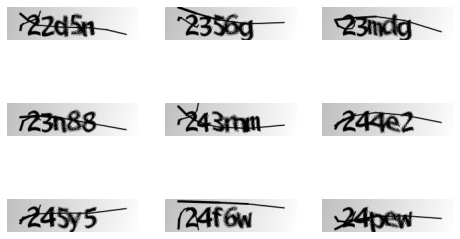

In [26]:
_, ax = plt.subplots(3, 3, figsize=(8, 5))
for i in range(9):
    img = cv2.imread(str(images[i]))
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].axis('off')
plt.show()

In [27]:
characters = set()
captcha_length = [] #store the length of each captca
dataset = []

In [28]:
for img_path in images:
    label = img_path.name.split(".png")[0]
    captcha_length.append(len(label))
    dataset.append((str(img_path), label))
    
    for ch in label:
        characters.add(ch)

In [33]:
characters = sorted(characters)

In [35]:
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

In [39]:
dataset = dataset.sample(frac=1.).reset_index(drop=True)
dataset.head(5)

,img_path,label
0,captcha_images_v2\c753e.png,c753e
1,captcha_images_v2\d4n82.png,d4n82
2,captcha_images_v2\5x7x5.png,5x7x5
3,captcha_images_v2\x277e.png,x277e
4,captcha_images_v2\pm363.png,pm363


In [47]:
print("Number of Unique Character in Dataset:", len(characters))
print("Number of character in any captcha:", Counter(captcha_length))
print("Character present:", characters)
print("total number of samples in dataset", len(dataset))

Number of Unique Character in Dataset: 19
Number of character in any captcha: Counter({5: 1039})
Character present: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
total number of samples in dataset 1039


In [86]:
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=10)

In [87]:
training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

In [88]:
char_to_labels = {char:idx for idx, char in enumerate(characters)}

In [89]:
labels_to_char = {val:key for key, val in char_to_labels.items()}

In [90]:
# checking for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
        return True

In [91]:
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """ Generates image array and labels array from a dataframe """
    num_items = len(df)
    
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0] * num_items
    
    for i in range(num_items):
        input_img = keras.preprocessing.image.load_img(df["img_path"][i], color_mode='grayscale')
        img_array = keras.preprocessing.image.img_to_array(input_img)
        
        if resize:
            img_array = np.resize(img_array, (img_height, img_width))
        
        img_array = (img_array/255.).astype(np.float32)
        
        label = df["label"][i]
        
        if is_valid_captcha(label):
            images[i, :, :] = img_array
            labels[i] = label
    return images, np.array(labels)

In [92]:
training_data, training_labels = generate_arrays(df=training_data)

In [93]:
print("Number of training images:", training_data.shape)
print("Number of training labels", training_labels.shape)

Number of training images: (935, 50, 200)
Number of training labels (935,)


In [94]:
validation_data, validation_labels = generate_arrays(validation_data)

In [95]:
print("Number of training images:", validation_data.shape)
print("Number of training labels", validation_labels.shape)

Number of training images: (104, 50, 200)
Number of training labels (104,)


In [139]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, 
                 data, 
                 labels, 
                 char_map, 
                 batch_size=16, 
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5, 
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [140]:
batch_size = 16

img_width = 200
img_height = 50

downsample_factor = 4
max_length = 5

In [141]:
train_data_generator = DataGenerator(data=training_data,
                                    labels=training_labels,
                                    char_map=char_to_labels)

In [142]:
valid_data_generator = DataGenerator(data=validation_data,
                                    labels=validation_labels,
                                    char_map=char_to_labels)

In [143]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return loss

In [144]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="input_data",dtype=tf.float32)
    labels = layers.Input(name="input_label", shape=[max_length], dtype=tf.float32)
    input_length = layers.Input(name="input_length", shape=[1], dtype=tf.int64)
    label_length = layers.Input(name="label_length", shape=[1], dtype=tf.int64)
    
    # first convolutional block
    
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='conv1')(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='conv2')(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((img_width//4), (img_height//4) * 64)
    x = layers.Reshape(new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='Dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNN
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # predictions
    x = layers.Dense(len(characters)+1, activation='softmax', name='dense2', kernel_initializer='he_normal')(x)
    
    # calculate ctc
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                              outputs=output,
                              name="OCR_MODEL")
    
    sgd = keras.optimizers.SGD(learning_rate=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    model.compile(optimizer=sgd)
    return model

In [145]:
model = build_model()


In [146]:
model.summary()

Model: "OCR_MODEL"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 200, 50, 32)  320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
__________________________________________________________________________________________

In [147]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=5,
                                  restore_best_weights=True)
cp = keras.callbacks.ModelCheckpoint("tmp")
logger = keras.callbacks.CSVLogger("logger.csv")

In [150]:
history = model.fit(train_data_generator,validation_data=valid_data_generator,epochs=50, callbacks=[es, logger])

Epoch 1/50
59/59 [==============================] - 4s 68ms/step - loss: 16.0208 - val_loss: 15.9363
Epoch 2/50
59/59 [==============================] - 4s 63ms/step - loss: 15.9863 - val_loss: 16.0993
Epoch 3/50
59/59 [==============================] - 4s 63ms/step - loss: 15.9803 - val_loss: 16.0058
Epoch 4/50
59/59 [==============================] - 4s 68ms/step - loss: 15.9573 - val_loss: 16.0166
Epoch 5/50
59/59 [==============================] - 4s 68ms/step - loss: 15.7285 - val_loss: 15.5428
Epoch 6/50
59/59 [==============================] - 4s 72ms/step - loss: 15.4165 - val_loss: 15.3268
Epoch 7/50
59/59 [==============================] - 5s 88ms/step - loss: 15.2154 - val_loss: 15.0465
Epoch 8/50
59/59 [==============================] - 4s 71ms/step - loss: 15.0165 - val_loss: 14.9105
Epoch 9/50
59/59 [==============================] - 4s 74ms/step - loss: 14.6683 - val_loss: 14.5087
Epoch 10/50
59/59 [==============================] - 7s 125ms/step - loss: 14.4271 - val_lo

<AxesSubplot:>

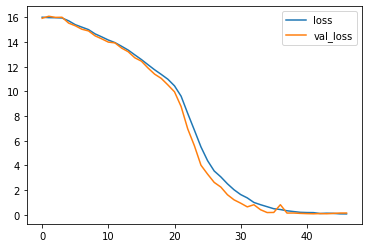

In [160]:
pd.DataFrame(history.history).plot()

In [152]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 200, 50, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
Dense1 (Dense)               (None, 50, 64)            49216 

In [162]:
sgd = keras.optimizers.SGD(learning_rate=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
prediction_model.compile(optimizer=sgd)

In [163]:
prediction_model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [164]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Ground truth: nwfde 	 Predicted: nwfde
Ground truth: 377xx 	 Predicted: 377xx
Ground truth: pyefb 	 Predicted: pyefb
Ground truth: 8w875 	 Predicted: 8w875
Ground truth: g888x 	 Predicted: g888x
Ground truth: excmn 	 Predicted: excmn
Ground truth: y5dpp 	 Predicted: y5dpp
Ground truth: yxd7m 	 Predicted: yxd7m
Ground truth: pf5ng 	 Predicted: pf5ng
Ground truth: gnf85 	 Predicted: gnf85
Ground truth: wm47f 	 Predicted: wm47f
Ground truth: b5fm7 	 Predicted: b5fm7
Ground truth: nfd8g 	 Predicted: nfd8g
Ground truth: gng6e 	 Predicted: gng6e
Ground truth: dnne7 	 Predicted: dnne7
Ground truth: 5nggg 	 Predicted: 5nggg
